In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from time_counter import time_counter

In [2]:
bbc_data = pd.read_csv("../data/clean_bbc_classification.csv")
sarc_data = pd.read_csv("../data/clean_sarcasm_classification.csv")

In [3]:
# Fine tuning params

num_iterations = 5
num_cv = 3

### RFC on BBC News Classification
#### Simple RFC

In [4]:
X = bbc_data['text']
y = bbc_data['label_ids']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [5]:
bbc_data[['labels', 'label_ids']].drop_duplicates()

,labels,label_ids
0,entertainment,0
386,business,1
896,sport,2
1407,politics,3
1824,tech,4


In [6]:
@time_counter
def model():
    rfc = RandomForestClassifier(n_jobs=-1)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    print("Simple Random Forest Classifier")
    print(classification_report(y_test, preds))
    return preds

preds, runtime_rfc_simple = model()
print(f"Runtime: {runtime_rfc_simple} seconds")
performance_rfc_simple = classification_report(y_test, preds, output_dict=True)

Simple Random Forest Classifier
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        65
           1       0.93      0.97      0.95       103
           2       0.97      1.00      0.98       114
           3       0.98      0.94      0.96        88
           4       0.99      0.95      0.97        75

    accuracy                           0.96       445
   macro avg       0.97      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445

Runtime: 0.61 seconds


In [7]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
importances_df = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
importances_df

,Feature,Importance
10247,film,0.010350
16790,mr,0.008430
16401,minister,0.008036
5647,champion,0.007641
10331,firm,0.007574
...,...,...
11098,gavi,0.000000
11096,gauge,0.000000
11095,gaudy,0.000000
11093,gatwick,0.000000


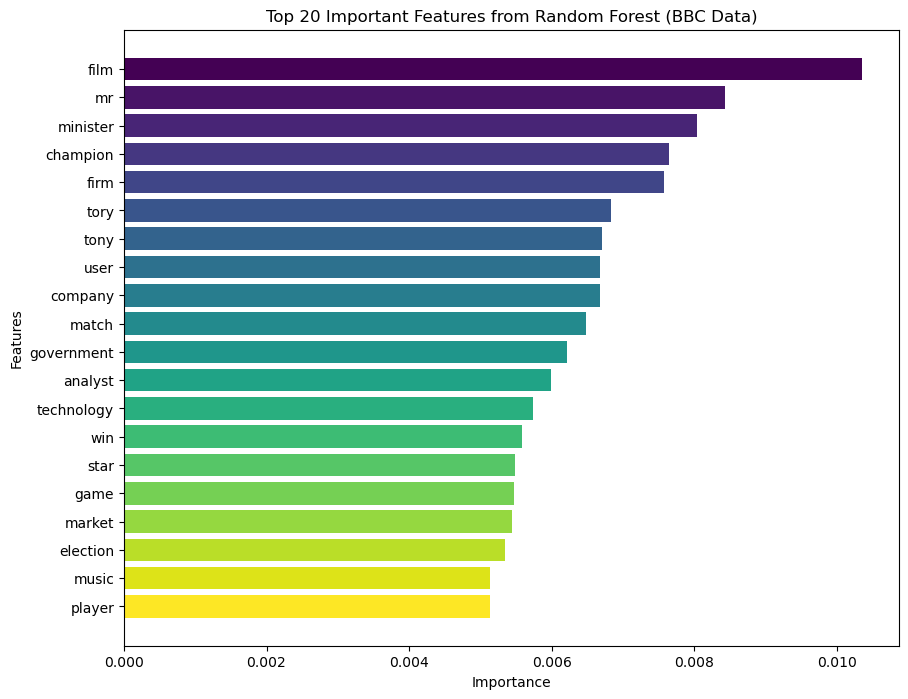

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Adjust the size to fit your needs
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20], color=plt.cm.viridis(np.linspace(0, 1, 20)))  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features from Random Forest (BBC Data)')
plt.gca().invert_yaxis()

#### Fine-tuned RFC

In [9]:
@time_counter
def model():
    rfc = RandomForestClassifier(n_jobs=-1)
    param_dist = {
        'n_estimators': [100, 200], 
        'max_depth': [None, 10, 20],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11),
        'criterion': ['gini', 'entropy']
    }

    rnd_cv = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                n_iter=num_iterations, cv=num_cv, scoring='accuracy', random_state=42, n_jobs=-1)
    rnd_cv.fit(X_train, y_train)
    print("Best parameters:", rnd_cv.best_params_)
    print("Best score:", rnd_cv.best_score_)
    rfc = RandomForestClassifier(**rnd_cv.best_params_, n_jobs=-1)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    print("Fine-tuned Random Forest Classifier")
    print(classification_report(y_test, preds))
    return preds

preds, runtime_rfc_tuned = model()
print(f"Runtime: {runtime_rfc_tuned} seconds")
performance_rfc_tuned = classification_report(y_test, preds, output_dict=True)


Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}
Best score: 0.955052681584441
Fine-tuned Random Forest Classifier
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        65
           1       0.93      0.97      0.95       103
           2       0.95      1.00      0.97       114
           3       0.99      0.94      0.97        88
           4       0.99      0.93      0.96        75

    accuracy                           0.96       445
   macro avg       0.96      0.95      0.96       445
weighted avg       0.96      0.96      0.96       445

Runtime: 8.9 seconds


In [10]:
data = pd.read_csv("../data/evaluation_data.csv")
data = pd.concat([data,
                  pd.DataFrame({
                      'Model': ['Random Forest', 'Random Forest fine-tuned'],
                      'Runtime': [runtime_rfc_simple, runtime_rfc_tuned],
                      'Accuracy': [performance_rfc_simple['accuracy'], performance_rfc_tuned['accuracy']],
                      'F1': [performance_rfc_simple['weighted avg']['f1-score'], performance_rfc_tuned['weighted avg']['f1-score']],
                      'data': ['bbc news', 'bbc news']
                  })], ignore_index=True)
data

,Model,Runtime,Accuracy,F1,data
0,Decision Tree,0.73,0.849438,0.849514,bbc news
1,Decision Tree fine-tuned,8.08,0.617978,0.632672,bbc news
2,Decision Tree,14.38,0.730084,0.729078,sarcasm detection
3,Decision Tree fine-tuned,8.67,0.615828,0.567973,sarcasm detection
4,Random Forest,0.42,0.970787,0.970774,bbc news
5,Random Forest fine-tuned,8.90,0.959551,0.959489,bbc news


### RFC on Sarcasm Detection
#### Simple RFC

In [11]:
sarc_data = sarc_data.dropna()
X = sarc_data['text']
y = sarc_data['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [12]:
@time_counter
def model():
    rfc = RandomForestClassifier(n_jobs=-1)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    print("Simple Random Forest Classifier")
    print(classification_report(y_test, preds))
    return preds

preds, runtime_rfc_simple = model()
print(f"Runtime: {runtime_rfc_simple} seconds")
performance_rfc_simple = classification_report(y_test, preds, output_dict=True)

Simple Random Forest Classifier
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      2978
           1       0.81      0.67      0.74      2746

    accuracy                           0.77      5724
   macro avg       0.77      0.76      0.76      5724
weighted avg       0.77      0.77      0.76      5724

Runtime: 10.27 seconds


#### Fine-tuned RFC

In [13]:
@time_counter
def model():
    rfc = RandomForestClassifier(n_jobs=-1)
    param_dist = {
        'n_estimators': [100, 200], 
        'max_depth': [None, 10, 20],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11),
        'criterion': ['gini', 'entropy']
    }

    rnd_cv = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                n_iter=num_iterations, cv=num_cv, scoring='accuracy', random_state=42, n_jobs=-1)
    rnd_cv.fit(X_train, y_train)
    print("Best parameters:", rnd_cv.best_params_)
    print("Best score:", rnd_cv.best_score_)
    rfc = RandomForestClassifier(**rnd_cv.best_params_, n_jobs=-1)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    print("Fine-tuned Random Forest Classifier")
    print(classification_report(y_test, preds))
    return preds

preds, runtime_rfc_tuned = model()
print(f"Runtime: {runtime_rfc_tuned} seconds")
performance_rfc_tuned = classification_report(y_test, preds, output_dict=True)


Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}
Best score: 0.7672753650402232
Fine-tuned Random Forest Classifier
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      2978
           1       0.79      0.71      0.75      2746

    accuracy                           0.77      5724
   macro avg       0.77      0.77      0.77      5724
weighted avg       0.77      0.77      0.77      5724

Runtime: 82.99 seconds


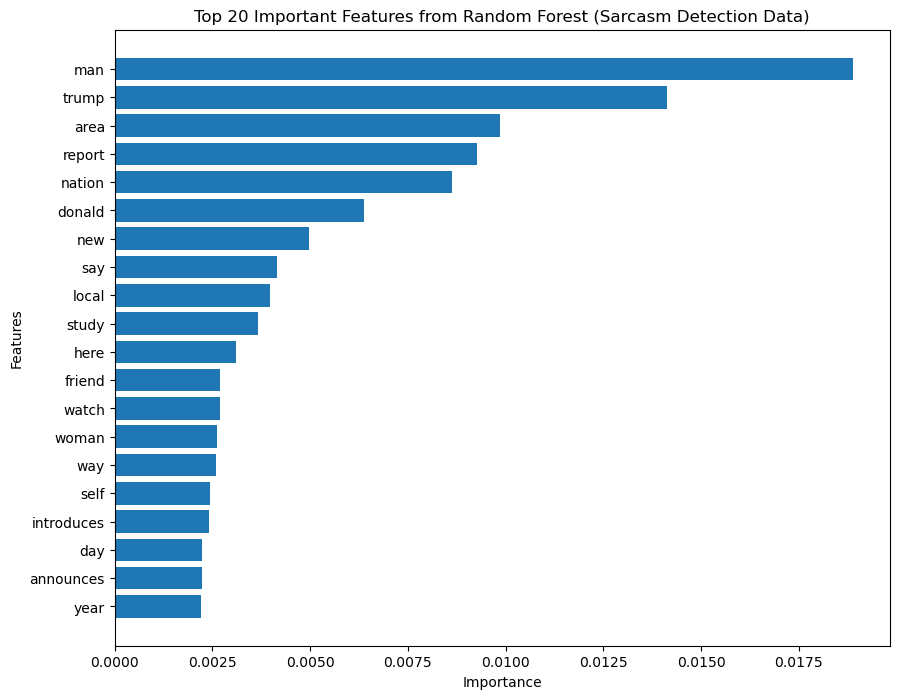

In [14]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)

importances_df = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8)) 
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features from Random Forest (Sarcasm Detection Data)')
plt.gca().invert_yaxis()

In [15]:
data = pd.concat([data,
                  pd.DataFrame({
                      'Model': ['Random Forest', 'Random Forest fine-tuned'],
                      'Runtime': [runtime_rfc_simple, runtime_rfc_tuned],
                      'Accuracy': [performance_rfc_simple['accuracy'], performance_rfc_tuned['accuracy']],
                      'F1': [performance_rfc_simple['weighted avg']['f1-score'], performance_rfc_tuned['weighted avg']['f1-score']],
                      'data': ['sarcasm detection', 'sarcasm detection']
                  })], ignore_index=True)
data

,Model,Runtime,Accuracy,F1,data
0,Decision Tree,0.73,0.849438,0.849514,bbc news
1,Decision Tree fine-tuned,8.08,0.617978,0.632672,bbc news
2,Decision Tree,14.38,0.730084,0.729078,sarcasm detection
3,Decision Tree fine-tuned,8.67,0.615828,0.567973,sarcasm detection
4,Random Forest,0.42,0.970787,0.970774,bbc news
5,Random Forest fine-tuned,8.90,0.959551,0.959489,bbc news
6,Random Forest,10.27,0.767121,0.764883,sarcasm detection
7,Random Forest fine-tuned,82.99,0.771139,0.770207,sarcasm detection


In [16]:
data.to_csv("../data/evaluation_data_2.csv", index=False)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Model     8 non-null      object 
 1   Runtime   8 non-null      float64
 2   Accuracy  8 non-null      float64
 3   F1        8 non-null      float64
 4   data      8 non-null      object 
dtypes: float64(3), object(2)
memory usage: 452.0+ bytes
